In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

### Data cleaning and preparation

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.columns = df.columns.str.lower()

In [4]:
status_values = {
    1: 'ok', 
    2: 'default', 
    0: 'ink'
}
df.status = df.status.map(status_values)

In [5]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [6]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [7]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [8]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [9]:
df = df[df.status !='ink'].reset_index(drop=True)

In [10]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state=11)

In [11]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [12]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [13]:
del df_train['status']
del df_val['status']
del df_test['status']

In [14]:
df_train

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,18,private,36,45,married,no,fixed,45,220.0,20000.0,0.0,800,1600
2668,7,private,60,29,married,no,fixed,60,51.0,3500.0,500.0,1000,1290
2669,1,parents,24,19,single,no,fixed,35,28.0,0.0,0.0,400,600
2670,15,owner,48,43,married,no,freelance,60,100.0,18000.0,0.0,2500,2976


### Decision trees

In [15]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] == 'parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'

In [16]:
xi = df_train.iloc[0].to_dict()

In [17]:
assess_risk(xi)

'ok'

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [ ]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [ ]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

In [ ]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [23]:
y_pred = dt.predict_proba(X_val)[:, 1]

In [24]:
roc_auc_score(y_val, y_pred)

0.6483404373834492

In [25]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

In [26]:
dt = DecisionTreeClassifier(max_depth=4)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4)

In [27]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.8164293560926146
val: 0.7612827250490422


In [28]:
from sklearn.tree import export_text

In [29]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- seniority <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- seniority >  0.50
|   |   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- assets <= 8250.00
|   |   |   |   |--- class: 1
|   |   |   |--- assets >  8250.00
|   |   |   |   |--- class: 0
|   |--- seniority >  6.50
|   |   |--- income <= 103.50
|   |   |   |--- assets <= 4500.00
|   |   |   |   |--- class: 1
|   |   |   |--- assets >  4500.00
|   |   |   |   |--- class: 0
|   |   |--- income >  103.50
|   |   |   |--- expenses <= 89.00
|   |   |   |   |--- class: 0
|   |   |   |--- expenses >  89.00
|   |   |   |   |--- class: 1
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- income <= 74.50
|   |   |   |--- assets <= 4250.00
|   |   |   |   |--- class: 0
|   |   |   |--- assets >  4250.00
|   |   |   |   |--- class: 0
|   |   |--- income >  74.50
|   |   |   |--- seniority <= 5.50
|   | 

### Decision tree algorithm

In [30]:
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [31]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [32]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [33]:
from IPython.display import display

In [34]:
for T in Ts:
    print(T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]
    
    display(df_left)
    print(df_left.status.value_counts(normalize=True))
    display(df_right)
    print(df_right.status.value_counts(normalize=True))
    
    print()

0


,assets,status
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64

2000


,assets,status
1,2000,default
2,0,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64

3000


,assets,status
1,2000,default
2,0,default
7,3000,default


default    1.0
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


ok         0.8
default    0.2
Name: status, dtype: float64

4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


ok         0.75
default    0.25
Name: status, dtype: float64

5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,status
0,8000,default
6,9000,ok


default    0.5
ok         0.5
Name: status, dtype: float64

8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,status
6,9000,ok


ok    1.0
Name: status, dtype: float64



In [35]:
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000, 500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [36]:
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [37]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

In [38]:
for feature, Ts in thresholds.items():
    print('################')
    print(feature)
    for T in Ts:
        print(T)
        df_left = df_example[df_example[feature] <= T]
        df_right = df_example[df_example[feature] > T]

        display(df_left)
        print(df_left.status.value_counts(normalize=True))
        display(df_right)
        print(df_right.status.value_counts(normalize=True))

        print()
    print('################')

################
assets
0


,assets,debt,status
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.666667
default    0.333333
Name: status, dtype: float64

3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


default    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


ok         0.8
default    0.2
Name: status, dtype: float64

4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


default    0.75
ok         0.25
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


ok         0.75
default    0.25
Name: status, dtype: float64

5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.5
ok         0.5
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


default    0.5
ok         0.5
Name: status, dtype: float64

8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64

################
################
debt
500


,assets,debt,status
6,9000,500,ok


ok    1.0
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


default    0.571429
ok         0.428571
Name: status, dtype: float64

1000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


ok         0.666667
default    0.333333
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


default    1.0
Name: status, dtype: float64

2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


ok         0.571429
default    0.428571
Name: status, dtype: float64


,assets,debt,status
0,8000,3000,default


default    1.0
Name: status, dtype: float64

################


### Decision trees parameters tuning

In [39]:
for d in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=d)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print(f'{d} -> {auc:.3f}')

1 -> 0.606
2 -> 0.669
3 -> 0.739
4 -> 0.761
5 -> 0.766
6 -> 0.749
10 -> 0.693
15 -> 0.660
20 -> 0.645
None -> 0.663


In [40]:
scores = []

for d in [4, 5, 6, 7, 10, 15, 20, None]:
    for s in [1, 2, 5, 10, 15, 20, 100, 200, 500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((d, s, auc))

In [41]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,min_samples_leaf,auc
0,4.0,1,0.761283
1,4.0,2,0.761283
2,4.0,5,0.761283
3,4.0,10,0.761283
4,4.0,15,0.763726


In [42]:
df_scores.sort_values(by='auc', ascending=False).head()

,max_depth,min_samples_leaf,auc
40,10.0,15,0.791371
49,15.0,15,0.787357
67,NaN,15,0.787030
58,20.0,15,0.786418
22,6.0,15,0.785319


In [43]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', 
                                  columns=['max_depth'], 
                                  values=['auc'])
df_scores_pivot.round(3)

auc                                                 
max_depth           NaN   4.0    5.0    6.0    7.0    10.0   15.0   20.0
min_samples_leaf                                                        
1                 0.659  0.761  0.767  0.758  0.743  0.702  0.656  0.657
2                 0.696  0.761  0.767  0.763  0.754  0.704  0.695  0.688
5                 0.714  0.761  0.768  0.762  0.755  0.729  0.718  0.720
10                0.761  0.761  0.762  0.778  0.764  0.768  0.761  0.760
15                0.787  0.764  0.772  0.785  0.780  0.791  0.787  0.786
20                0.784  0.761  0.774  0.773  0.779  0.785  0.781  0.782
100               0.780  0.756  0.763  0.776  0.780  0.779  0.779  0.780
200               0.768  0.747  0.759  0.768  0.768  0.768  0.768  0.768
500               0.680  0.680  0.680  0.680  0.680  0.680  0.680  0.680

<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

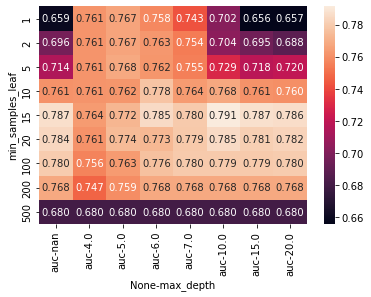

In [44]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [45]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

### Ensembles and random forest

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [48]:
y_pred = rf.predict_proba(X_val)[:, 1]

In [49]:
roc_auc_score(y_val, y_pred)

0.7744726453706618

In [50]:
rf.predict_proba(X_val[[0]])

array([[0.9, 0.1]])

In [51]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n, auc))

In [52]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

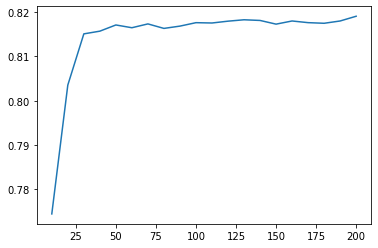

In [53]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [54]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, 
                                    max_depth=d, 
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n, auc))

In [55]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

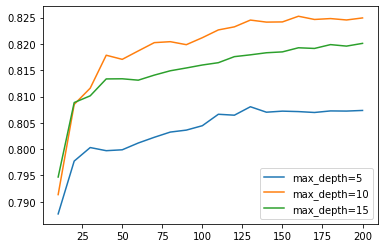

In [56]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label=f'max_depth={d}')

plt.legend()

In [57]:
max_depth = 10

In [58]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, 
                                    max_depth=max_depth, 
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((s, n, auc))

In [59]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

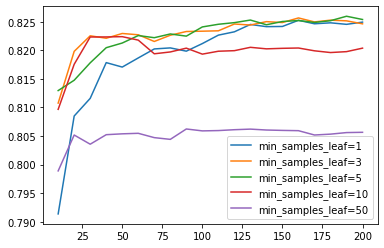

In [60]:
for s in [1, 3, 5, 10, 50]:
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.auc, label=f'min_samples_leaf={s}')

plt.legend()

In [61]:
min_samples_leaf = 3

In [62]:
rf = RandomForestClassifier(n_estimators=100,
                            max_depth=max_depth, 
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, random_state=1)

### Gradient boosting and XGBoost

In [63]:
import xgboost as xgb

In [64]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [73]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6, 
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=10)

[15:58:53] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1631904775127/work/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [74]:
y_pred = model.predict(dval)

In [75]:
roc_auc_score(y_val, y_pred)

0.8152745150274878

In [76]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [82]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6, 
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=200, 
                  verbose_eval=5, evals=watchlist)

In [89]:
line = output.stdout.split('\n')[0]

In [96]:
num_iter, train_auc, val_auc = line.split('\t')

In [97]:
int(num_iter.strip('[]'))

0

In [98]:
float(train_auc.split(':')[1])

0.863

In [99]:
float(val_auc.split(':')[1])

0.76818

In [100]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [102]:
df_score = parse_xgb_output(output)

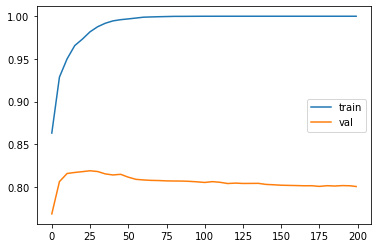

In [103]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()